# Paraíba do Sul Simulator Results Exploring

## Imports libraries:

In [291]:
using simulatorParaibaDoSul, DataFrames, CSV, Dates, Measures, Statistics, StatsPlots
gr()

Plots.GRBackend()

## Runs simulation to gather results from example case:

In [292]:
dir = "study_case"
run_simulation(dir)

"Simulation complete, results available at ./results/study_case"

## Reads results from output files:

In [293]:
df_generation = DataFrame(CSV.File(joinpath("results",dir,dir*"_generation_MW.csv")))
df_turbining = DataFrame(CSV.File(joinpath("results",dir,dir*"_turbining_m3_per_sec.csv")))
df_spillage = DataFrame(CSV.File(joinpath("results",dir,dir*"_spillage_m3_per_sec.csv")))
first(df_generation, 5)

,step,month,stage,ps_equivalent_reservoir,paraibuna,simplicio,sta_branca
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,1,0.927219,8.22244,265.262,10.1933
2,2,2,1,0.99829,87.9353,265.262,43.8082
3,3,3,1,1.0,87.9353,265.262,51.2906
4,4,4,1,1.0,60.1794,265.262,35.7985
5,5,5,1,1.0,44.9263,255.219,26.4925


## Plots Paraíba do Sul equivalent reservoir over time, and respective depletion stages:

### The correlation between the equivalent reservoir and depletion stages become clear. Periods of increase or decrease in flow are visible and most of the times periodical.

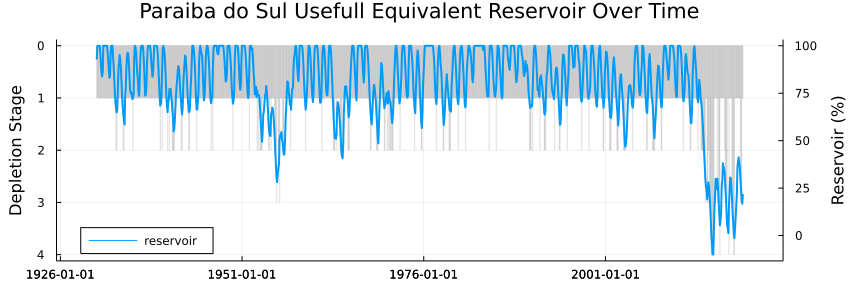

In [294]:
time = Date(1931):Month(1):Date(1931)+Month(size(df_generation,1)-1)
eq_reservoir = df_generation[:,"ps_equivalent_reservoir"]
stages = df_generation[:,"stage"]

bar(time,stages,
    ylabel = "Depletion Stage",
    color = "grey",
    alpha = 0.08,
    legend = false,
    size = (900,300),
    title = "Paraiba do Sul Usefull Equivalent Reservoir Over Time",
    margin=5mm,
    right_margin = 15mm,
    bar_spacing = 0mm,
    yflip = true
)


plot!(twinx(),time,eq_reservoir*100,
    label = "reservoir",
    ylabel = "Reservoir (%)",
    lw = 2,
    margin=5mm,
    size = (850,300),
    legend = :bottomleft
)

## Plots Santa Cecilia Turbining and Spillage Distributions:

### Relavant values, such as minimum turbining and spillage, can be easily noticed and reference its operation protocol. 

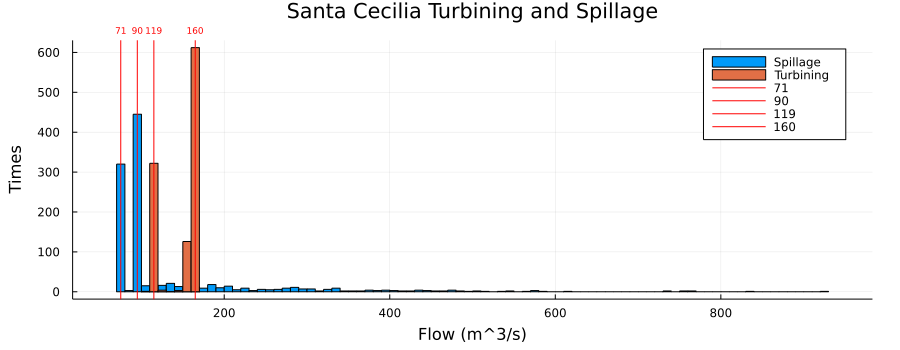

In [295]:
sta_cecilia_spillage = df_spillage[:,"sta_cecilia"]
sta_cecilia_turbining = df_turbining[:,"sta_cecilia"]

df_sta_cecilia = DataFrame(Dict(
    "Turbining m^{3}/s" => sta_cecilia_turbining,
    "Spillage m^{3}/s" => sta_cecilia_spillage,
))

histogram(sta_cecilia_spillage,
    bins = 100,
    label = "Spillage",
    title = "Santa Cecilia Turbining and Spillage",
    xlabel = "Flow (m^3/s)",
    ylabel = "Times",
    size = (900,350),
    margin = 5mm
)
histogram!(sta_cecilia_turbining,
    label = "Turbining"
)

plot!([75], seriestype="vline",color=:red,label = "71")
annotate!(75, 655, text(string(71), :red, 6))

plot!([90+5], seriestype="vline",color=:red,label="90")
annotate!(90+5, 655, text(string(90), :red, 6))

plot!([110+5], seriestype="vline",color=:red,label="119")
annotate!(110+5, 655, text(string(119), :red, 6))

p = plot!([165], seriestype="vline",color=:red,label="160")
annotate!(165, 655, text(string(160), :red, 6))
p

## Plots Average Generations of the simulator vs SUISHI:

### It can be seen that the values are very close to each other.

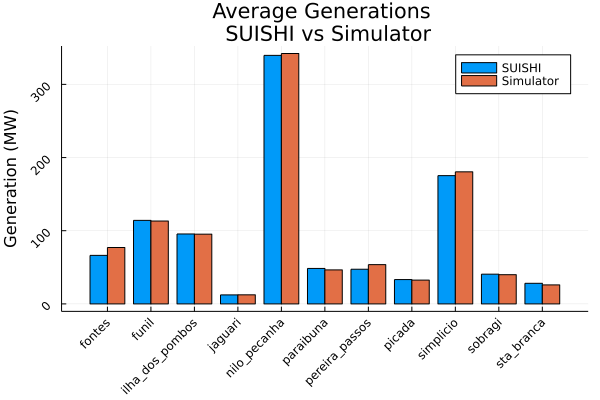

In [296]:
df_generation[:,"fontes"] = df_generation[:,"fontes_a"] + df_generation[:,"fontes_bc"]
labels = [
    "paraibuna",
    "simplicio",
    "sta_branca",
    "jaguari",
    "ilha_dos_pombos",
    "funil",
    "sobragi",
    "fontes",
    "nilo_pecanha",
    "picada",
    "pereira_passos"
]
simulator_means = mean.(eachcol(df_generation[:,labels]))
suishi_means = [48.425, 175.28, 28.154, 12.288, 95.542, 114.145, 40.571, 66.286, 339.645, 33.178, 47.305]
StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means suishi_means],
    rotation = 45,
    title = "Average Generations \n SUISHI vs Simulator",
    ylabel = "Generation (MW)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "SUISHI"], inner = 11)
)

## Plots Average Generations of the simulator on the critical period vs all the time:

### As expected, values during the critical period are slightly lower than usual.

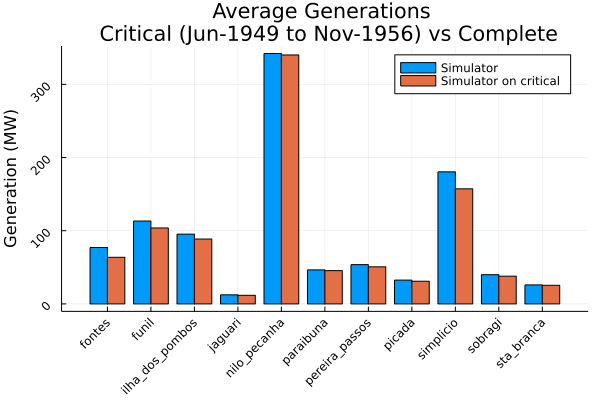

In [297]:
df_critical = df_generation[222:311,labels]
bar(labels,sum.(eachcol(df_critical)),
    rotation = 45,
    bottom_margin = 8mm,
    title = "Total Generation Critical Period \n (Jun-1949 to Nov-1956)",
    legend = false,
    ylabel = "Generation (MW)"
)

simulator_means = mean.(eachcol(df_generation[:,labels]))
critical_means = mean.(eachcol(df_critical))

p =StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means critical_means],
    rotation = 45,
    title = "Average Generations \n Critical (Jun-1949 to Nov-1956) vs Complete",
    ylabel = "Generation (MW)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "Simulator on critical"], inner = 11)
)
p

## Calculates total average generation during critical period:

In [298]:
v = sum(mean.(eachcol(df_critical)))
println("TOTAL AVERAGE GENERATION ON CRITICAL PERIOD (MW): $(v)")

TOTAL AVERAGE GENERATION ON CRITICAL PERIOD (MW): 955.5252326764441
